<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/Anomaly1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import random
from skimage.metrics import structural_similarity as ssim

In [ ]:
# 정상 데이터
train_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/train/good/*')
# 이상 데이터들
test_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_large/*')
test_dir_broken_small = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_small/*')
test_dir_contamination = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/contamination/*')

# 정상 테스트 데이터
test_dir_good = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/good/*')

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []
test_images_good = []
test_labels_good = []
target_size = (224, 224)

In [ ]:
# 정상 데이터가 들어있는 훈련용 데이터세트
train_dir = train_dir
# 이상 데이터가 들어있는 훈련용 데이터세트
test_dir = test_dir + test_dir_broken_small + test_dir_contamination
# 정상 데이터만 들어가있는 테스트용 데이터세트
test_dir_good = test_dir_good

In [ ]:
# 데이터셋 내의 모든 이미지 파일에 대해 resize 작업과 픽셀 값 정규화 작업
# 이미지 로드 및 리사이징
for img_path in train_dir:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    train_images.append(normalized_img_array)
    train_labels.append(0)
#test_dir_broken_small + test_dir_contamination
for img_path in test_dir + test_dir_broken_small + test_dir_contamination:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)  # 수정: img_array 대신 resized_img를 사용
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images.append(normalized_img_array)
    test_labels.append(1)

In [ ]:
for img_path in test_dir_good:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images_good.append(normalized_img_array)
    test_labels_good.append(0)

In [ ]:
# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# 정상과 비정상 데이터를 합친 전체 데이터셋
all_images = train_images + test_images
all_labels = train_labels + test_labels
# 테스트를 위한 정상 데이터세트가 들어있는 데이터셋
test_dir_good
# 데이터를 훈련 세트와 검증 세트로 분리
train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                      all_labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

In [ ]:
# numpy배열로 변환
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [ ]:
# 클래스 수 (이진 분류 - 정상: 0, 비정상: 1)
num_classes = 1
# ResNet-50 모델 불러오기 (pre-trained 가중치 사용)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 fully connected layer 추가하기
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='relu')(x)
x = Dropout(0.5)(x)  # 드롭아웃 적용 (0.5는 드롭아웃 비율로 50%의 뉴런을 랜덤하게 비활성화)
predictions = Dense(num_classes, activation='sigmoid')(x)  # 이진 분류이므로 activation을 sigmoid로 변경

# 전체 모델 정의하기
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# 기존의 ResNet-50 모델 가중치 동결하기
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일하기
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 훈련하기
epochs = 10
history = model.fit(train_images, train_labels, epochs=epochs, validation_split=0.2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
7/7 [==============================] - 25s 1s/step - loss: 0.6860 - accuracy: 0.6468 - val_loss: 0.6850 - val_accuracy: 0.6863
Epoch 2/10
7/7 [==============================] - 1s 154ms/step - loss: 0.6865 - accuracy: 0.6468 - val_loss: 0.6845 - val_accuracy: 0.6863
Epoch 3/10
7/7 [==============================] - 1s 164ms/step - loss: 0.6847 - accuracy: 0.6468 - val_loss: 0.6840 - val_accuracy: 0.6863
Epoch 4/10
7/7 [==============================] - 1s 164ms/step - loss: 0.6854 - accuracy: 0.6468 - val_loss: 0.6835 - val_accuracy: 0.6863
Epoch 5/10
7/7 [==============================] - 1s 164ms/step - loss: 0.6865 - accuracy: 0.6468 - val_loss: 0.6829 - val_accuracy: 0.6863
Epoch 6/10
7/7 [==============================] - 1s 164ms/step - loss: 0.6880 - accuracy: 0.6468 - val_loss: 0.6826 - val_accuracy: 0.6863
Epoch 7/10
7/7 [==============================] - 1s 151ms/step - loss: 0.6904 - accuracy: 0.6468 - val_loss: 0.6823 - val_accuracy: 0.6863
Epoch 8/10
7/7 [======

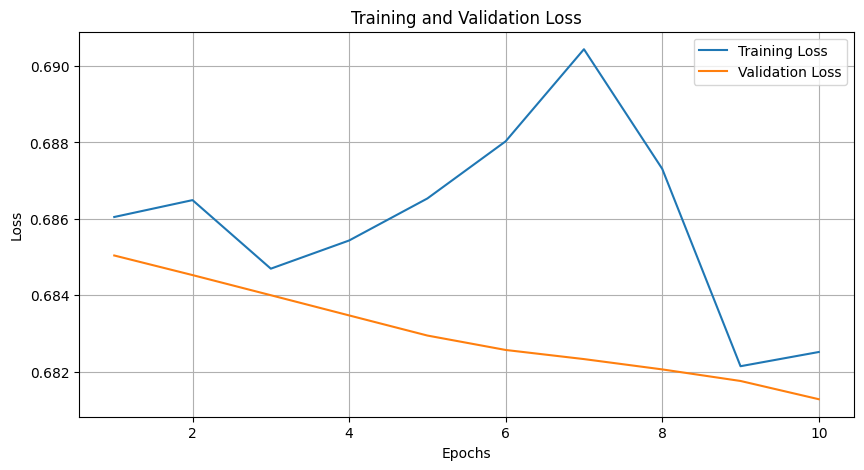

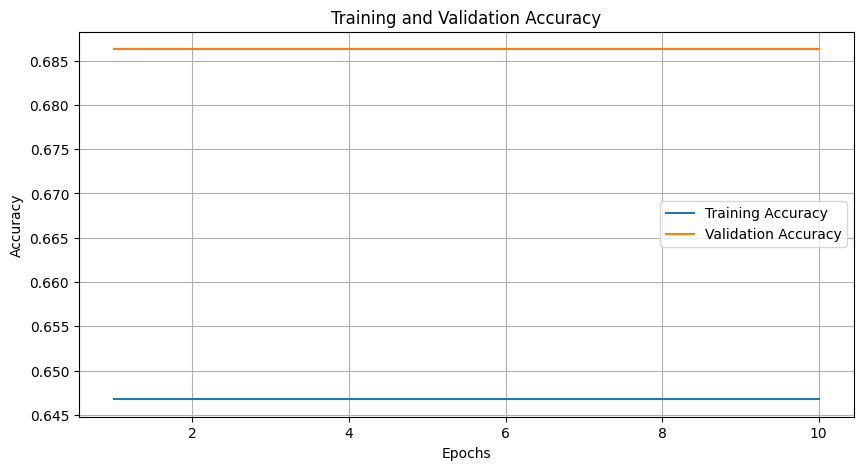

In [ ]:
# 학습 결과를 기록한 history 객체에서 Loss와 Accuracy 추출
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch 수
epochs_range = range(1, epochs + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# train_images 는 현재 학습된 데이터들중 하나를 선택
# test_images 는 현재 학습되지 않은 데이터중 하나를 선택
train_ori_images = [img for img, label in zip(all_images, all_labels) if label == 0]
train_anomaly_images = [img for img, label in zip(all_images, all_labels) if label == 1]

# 모든 훈련 데이터가 들어가있는 데이터셋
train_ori_images = train_ori_images + train_anomaly_images

test_images = [img for img, label in zip(test_images_good, test_labels_good) if label == 0]

print(len(train_ori_images))

315


In [ ]:
def compare_images(image1, image2):
    # 이미지를 그레이스케일로 변환
    gray_image1 = np.mean(image1, axis=2)
    gray_image2 = np.mean(image2, axis=2)

    # 이미지 비교
    (score, _) = ssim(gray_image1, gray_image2, full=True)
    return score

# 두 개의 이미지 비교
def classify_images(image1, image2):
    similarity_score = compare_images(image1, image2)
    return similarity_score

In [ ]:
# 전체 train_images와 test_images 비교하여 일치율 리스트 생성
similarity_list = []
for image1 in train_ori_images:
    similarity_scores = [classify_images(image1, image2) for image2 in test_images]
    similarity_list.append(similarity_scores)

# 각 train 이미지에 대한  계산
average_similarity_list = [np.mean(scores) for scores in similarity_list]

# 전체데이터의 평균 일치율값
average_similarity_total = np.mean(average_similarity_list)
print("전체 Train 이미지에 대한 평균 일치율: {:.2f}%".format(average_similarity_total * 100))

전체 Train 이미지에 대한 평균 일치율: 80.47%


이상값 개수: 121
이상값의 인덱스: [1, 4, 19, 26, 28, 31, 33, 36, 38, 44, 46, 47, 49, 50, 52, 55, 57, 60, 61, 66, 68, 73, 85, 87, 94, 95, 98, 103, 108, 110, 111, 117, 118, 120, 130, 132, 139, 144, 149, 153, 159, 160, 163, 166, 167, 175, 186, 193, 197, 200, 210, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 226, 227, 229, 231, 233, 235, 237, 238, 240, 245, 247, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 267, 268, 269, 271, 272, 274, 276, 278, 280, 281, 283, 288, 290, 292, 293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 307, 308, 310, 311, 312, 314, 315]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

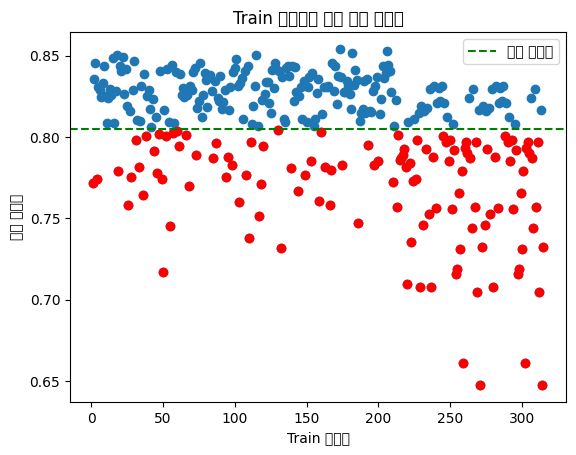

In [ ]:
# 이상값 탐색 (평균 일치율이 기준보다 낮은 값들)
threshold = average_similarity_total
outliers = [idx+1 for idx, score in enumerate(average_similarity_list) if score < threshold]

# 이상값 개수와 해당 인덱스 출력
print("이상값 개수:", len(outliers))
print("이상값의 인덱스:", outliers)

# 평균 일치율 데이터로 산점도 그래프 그리기
plt.scatter(range(1, len(average_similarity_list) + 1), average_similarity_list)
plt.scatter(outliers, [average_similarity_list[idx-1] for idx in outliers], color='red')
plt.axhline(average_similarity_total, color='green', linestyle='--', label='평균 일치율')
plt.xlabel('Train 이미지')
plt.ylabel('평균 일치율')
plt.title('Train 이미지에 대한 평균 일치율')
plt.legend()
plt.show()

랜덤 선택된 이상값 (Train 이미지 280) 출력:


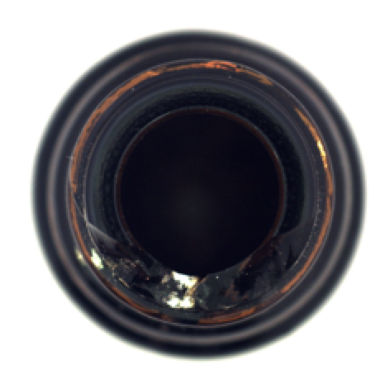

이상값의 일치율: 0.71


In [ ]:
# 랜덤하게 이상값 이미지 하나 선택
random_outlier_idx = random.choice(outliers) - 1  # 이상값 인덱스는 1부터 시작하므로 변환
random_outlier_train_image = train_ori_images[random_outlier_idx]

print(f"랜덤 선택된 이상값 (Train 이미지 {random_outlier_idx + 1}) 출력:")
plt.imshow(random_outlier_train_image)
plt.axis('off')
plt.show()

# 이상값의 일치율 계산
outlier_similarity = average_similarity_list[random_outlier_idx]
print(f"이상값의 일치율: {outlier_similarity:.2f}")

In [ ]:
# 정상값 개수 계산
normal_count = len(train_ori_images) - len(outliers)

# 훈련 데이터의 전체 데이터 대비 이상치 비율 계산
total_data_count = len(train_ori_images)
outlier_ratio = (len(outliers) / total_data_count) * 100

# 훈련 데이터의 이상값과 정상값 개수 비교
print("훈련 데이터의 이상값 개수:", len(outliers))
print("훈련 데이터의 정상값 개수:", normal_count)
print("훈련 데이터의 이상치 비율:", len(outliers) / 272)

훈련 데이터의 이상값 개수: 121
훈련 데이터의 정상값 개수: 194
훈련 데이터의 이상치 비율: 0.44485294117647056


In [ ]:
print("원래 데이터의 이상값 개수:", len(test_dir))
print("원래 데이터의 정상값 개수:", len(train_dir))
print("원래 데이터의 이상치 비율:", len(test_dir) / 272)

원래 데이터의 이상값 개수: 63
원래 데이터의 정상값 개수: 209
원래 데이터의 이상치 비율: 0.23161764705882354
